## Define Variables / Import MetaData

In [27]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import hvplot.xarray
# import holoviews as hv
from cartopy import crs as ccrs 
import cartopy.feature as cfeature
import datetime
import glob
import os
import pprint

In [20]:
import plotly.express as px
import seaborn as sns

In [5]:
# Define misc variables
amer_filepath = '../ameriflux-data/'
mic_filepath = '../intermediates/'
timedelta = 'DD'

In [6]:
# Import site metadata csv
meta_file = amer_filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] 

In [7]:
total_sites = fluxnet_meta['Site ID'].to_list()
len(total_sites)

196

In [8]:
# set map proj
proj=ccrs.PlateCarree()

In [9]:
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [10]:
def get_amer_match(amer_filepath, site_ID):
    match = get_single_match(amer_filepath + 'AMF_' + site_ID +
                            '_FLUXNET_SUBSET_*/AMF_' + site_ID +
                            '_FLUXNET_SUBSET_' + timedelta + '*.csv')
    return match

## Preprocessing

### 1. Check sites that aren't preprocessed or plotted

In [ ]:
# Get list of files and create dataframe with truncated filenames
plots_list = !ls plots/
plotted_sites = list([filename.split('_')[0] for filename in plots_list])

In [ ]:
len(plotted_sites)

In [ ]:
# Find missing sites that are not plotted:
missing_plots = [item for item in total_sites
                if item not in plotted_sites]

missing_df = pd.DataFrame(missing_plots, columns=['Missing from Plots'])
missing_df

In [ ]:
# What about intermediates?
intermediates_list = !ls intermediates/
processed_sites = list([filename.split('_')[0] for filename in intermediates_list])

In [ ]:
missing_processed = [item for item in total_sites
                if item not in processed_sites]
missing_df2 = pd.DataFrame(missing_processed, columns=['Missing from Intermediates'])
missing_df2

##### No longer missing! Bugs fixed

### 2. Debugging pre 2001 FLUXNET data

In [ ]:
def get_single_match(pattern):
  matches = glob.glob(pattern)
  if len(matches) == 1:
      return matches[0]
  elif len(matches) == 0:
      raise ValueError(f"No matches found for: {pattern}")
  else:
      raise ValueError(f"Multiple matches found: {matches}")

timedelta = 'DD'
micasa_var_list = ['NEE', 'NPP']

#Import list of fluxnet sites
meta_file = amer_filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only
fluxnet_list = fluxnet_meta['Site ID'].to_list()

In [ ]:
# see the dates for the erroring sites
for site_ID in fluxnet_list:
    # Open site data and access time indices
    site_file = get_single_match(amer_filepath + 'AMF_' + site_ID +
                              '_FLUXNET_SUBSET_*/AMF_' + site_ID +
                              '_FLUXNET_SUBSET_' + timedelta + '*.csv')
    fluxnet_sel = pd.read_csv(site_file)
    
    # select subset of columns + convert to datetime objects
    fluxnet_sel_dates = fluxnet_sel.loc[:,['TIMESTAMP']].copy()
    fluxnet_sel_dates['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_dates['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_dates = fluxnet_sel_dates.set_index('TIMESTAMP')
    
    # Create a list of unique dates from the site
    time = fluxnet_sel_dates.index
    dates_unique = list({dt.date() for dt in time})
    dates_unique.sort()

    
    # Extract micasa data
    path = '../micasa-data/daily-0.1deg-final/holding/'
    data_path = path + 'daily/'
    
    path_list = []
    for date in dates_unique:
        f_year = str(date.year)
        f_month = f"{date.month:02}"
        filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
        try:
            get_single_match(os.path.join(data_path,f_year,f_month,filename))
        except ValueError as e:
            print(f"{site_ID} has Fluxnet data for: {dates_unique[0]} to {dates_unique[-1]}")
            break

In [ ]:
# try to skip the error for one site
site_ID = "CA-Ca1"

# Open site data and access time indices
site_file = get_single_match(amer_filepath + 'AMF_' + site_ID +
                          '_FLUXNET_SUBSET_*/AMF_' + site_ID +
                          '_FLUXNET_SUBSET_' + timedelta + '*.csv')
fluxnet_sel = pd.read_csv(site_file)

# select subset of columns + convert to datetime objects
fluxnet_sel_dates = fluxnet_sel.loc[:,['TIMESTAMP']].copy()
fluxnet_sel_dates['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_dates['TIMESTAMP'],format='%Y%m%d')
fluxnet_sel_dates = fluxnet_sel_dates.set_index('TIMESTAMP')

# Create a list of unique dates from the site
time = fluxnet_sel_dates.index
dates_unique = list({dt.date() for dt in time})
dates_unique.sort()


# Extract micasa data
path = '../micasa-data/daily-0.1deg-final/holding/'
data_path = path + 'daily/'
# print(data_path)
path_list = []
for date in dates_unique:
    f_year = str(date.year)
    f_month = f"{date.month:02}"
    filename = 'MiCASA_v1_flux_*' + date.strftime('%Y%m%d') + '.nc4'
    try:
        filepath = get_single_match(os.path.join(data_path,f_year,f_month,filename))
        path_list.append(filepath)
    except ValueError as e:
        continue

In [ ]:
print(dates_unique[0])
path_list[0]

## Land Mask

### FluxNet Land Type / Tables of Site lat/lon for Brad

In [11]:
# fluxnet_meta.head()

In [12]:
summary_table = fluxnet_meta[['Site ID','Latitude (degrees)','Longitude (degrees)', 'Vegetation Abbreviation (IGBP)', 'Vegetation Description (IGBP)', 'Climate Class Abbreviation (Koeppen)', 'Climate Class Description (Koeppen)']]
summary_table

,Site ID,Latitude (degrees),Longitude (degrees),Vegetation Abbreviation (IGBP),Vegetation Description (IGBP),Climate Class Abbreviation (Koeppen),Climate Class Description (Koeppen)
5,AR-TF1,-54.9733,-66.7335,WET,Permanent Wetlands: Lands with a permanent mix...,NaN,NaN
9,BR-CST,-7.9682,-38.3842,DNF,Deciduous Needleleaf Forests: Lands dominated ...,Bsh,Steppe: very cold winter
18,BR-Npw,-16.4980,-56.4120,WSA,Woody Savannas: Lands with herbaceous and othe...,Aw,Tropical savanna
25,CA-ARB,52.6950,-83.9452,WET,Permanent Wetlands: Lands with a permanent mix...,Dfb,Warm Summer Continental: significant precipita...
26,CA-ARF,52.7008,-83.9550,WET,Permanent Wetlands: Lands with a permanent mix...,Dfb,Warm Summer Continental: significant precipita...
...,...,...,...,...,...,...,...
664,US-xTR,45.4937,-89.5857,DBF,Deciduous Broadleaf Forests: Lands dominated b...,Dfb,Warm Summer Continental: significant precipita...
665,US-xUK,39.0404,-95.1921,DBF,Deciduous Broadleaf Forests: Lands dominated b...,Cfa,"Humid Subtropical: mild with no dry season, ho..."
666,US-xUN,46.2339,-89.5373,MF,Mixed Forests: Lands dominated by trees with a...,Dfb,Warm Summer Continental: significant precipita...
667,US-xWD,47.1282,-99.2414,GRA,Grasslands: Lands with herbaceous types of cov...,Dfb,Warm Summer Continental: significant precipita...


In [13]:
# make csv summary
# summary_table.to_csv('ameriflux-data/Ameriflux_summary_table.csv')

### Plot AmeriFlux sites

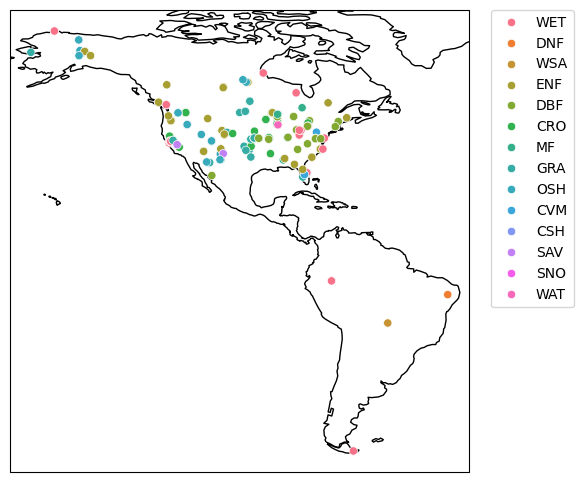

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw= {'projection': proj})
ax.add_feature(cfeature.COASTLINE,zorder=0)
sns.scatterplot(x='Longitude (degrees)', y='Latitude (degrees)', data=summary_table, hue='Vegetation Abbreviation (IGBP)', ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
# Plot vegetation abbreviation?
veg_dict = dict(zip(summary_table['Vegetation Abbreviation (IGBP)'].unique(),summary_table['Vegetation Description (IGBP)'].unique()))

In [15]:
pprint.pprint(veg_dict)

{'CRO': 'Croplands: Lands covered with temporary crops followed by harvest and '
        'a bare soil period (e.g., single and multiple cropping systems). Note '
        'that perennial woody crops will be classified as the appropriate '
        'forest or shrub land cover type.',
 'CSH': 'Closed Shrublands: Lands with woody vegetation less than 2 meters '
        'tall and with shrub canopy cover >60%. The shrub foliage can be '
        'either evergreen or deciduous.',
 'CVM': 'Cropland/Natural Vegetation Mosaics: Lands with a mosaic of '
        'croplands, forest, shrublands, and grasslands in which no one '
        'component comprises more than 60% of the landscape',
 'DBF': 'Deciduous Broadleaf Forests: Lands dominated by woody vegetation with '
        'a percent cover >60% and height exceeding 2 meters.  Consists of '
        'broadleaf tree communities with an annual cycle of leaf-on and '
        'leaf-off periods.',
 'DNF': 'Deciduous Needleleaf Forests: Lands dominated by 

### MiCASA Land Mask

In [14]:
!ls ../../landmask

MiCASA_v1_cover_x3600_y1800_yearly_2001.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2002.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2003.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2004.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2005.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2006.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2007.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2008.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2009.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2010.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2011.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2012.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2013.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2014.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2015.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2016.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2017.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2018.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2019.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2020.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2021.nc4
MiCASA_v1_cover_x3600_y1800_yearly_2022.nc4
MiCASA_v1_cover_x3600_y1800_year

In [9]:
# Import landmask file for 2001
landmask_filepath = '../../landmask/'
year = str(2001)
ds = xr.open_dataset(landmask_filepath + 'MiCASA_v1_cover_x3600_y1800_yearly_' + year + '.nc4')

In [10]:
ds.ftype

<xarray.DataArray 'ftype' (type: 18, lat: 1800, lon: 3600)> Size: 467MB
[116640000 values with dtype=float32]
Coordinates:
  * type     (type) int16 36B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * lat      (lat) float32 7kB -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
Attributes: (12/18)
    1:        Evergreen Needleleaf Forests
    2:        Evergreen Broadleaf Forests
    3:        Deciduous Needleleaf Forests
    4:        Deciduous Broadleaf Forests
    5:        Mixed Forests
    6:        Closed Shrublands
    ...       ...
    13:       Urban and Built-up Lands
    14:       Cropland/Natural Vegetation Mosaics
    15:       Permanent Snow and Ice
    16:       Barren
    17:       Water Bodies
    18:       Unclassified

In [11]:
ds_water = ds.ftype.sel(type=17)

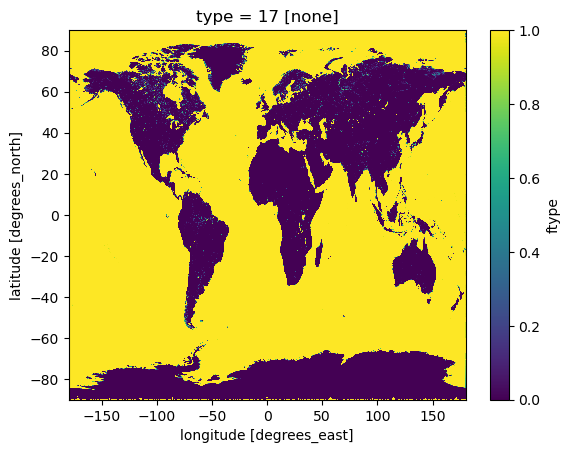

In [12]:
ds_water.plot()

In [15]:
# ds.ftype.hvplot(x='lat',y='lon', 
#                 crs=proj,
#                size=150)

## Coastal Site Issue

In [ ]:
site_ID = 'US-KS3' # example site that is showing up weird
# Extract site lat/lon
site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values[0]
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values[0]
print(site_lat, site_lon)

In [ ]:
# Approx location of site
ax = plt.subplot(projection=proj,frameon=False)
if site_lat >= 20:
    # North America extents
    min_lon, max_lon = -170, -57
    min_lat, max_lat = 25, 74

else:
    # South America extents
    min_lon, max_lon = -90, -30
    min_lat, max_lat = -60, 12

ax.axis('off')
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(site_lon,site_lat,
       marker='*', 
       s=500,
       color='yellow',
       edgecolor='black',
               zorder=3)

In [ ]:
# Subset data for plotting
min_lon, max_lon = site_lon-5, site_lon+5
min_lat, max_lat = site_lat-2, site_lat+2

#### Single file

In [ ]:
# single_path_test = glob.glob('/discover/nobackup/hzafar/ghgc/micasa/micasa-data/daily-0.1deg-final/holding/daily/2016/01/MiCASA_v1_flux_x3600_y1800_daily_20160104*')

# test_ds = xr.open_dataset(single_path_test[0])['NEE']
# ds_subset = test_ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon,max_lon)).isel(time=0)
# ds_subset

#### Multifile

In [ ]:
mult_path_test = glob.glob('/discover/nobackup/hzafar/ghgc/micasa/micasa-data/daily-0.1deg-final/holding/daily/2016/01/MiCASA_v1_flux_x3600_y1800_daily_201601*')
mult_ds = xr.open_mfdataset(mult_path_test, combine="by_coords", chunks={})['NEE']
ds_subset = mult_ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon,max_lon))
ds_subset

In [ ]:
mesh_plot = ds_subset.hvplot(x="lon", y="lat",
                      cmap='RdBu_r',
                  clim=(-1e-8,1e-8),
                      crs = proj,
                      # rasterize=True,
                 frame_width = 500,
                 # widget_location='bottom'
                     )
# mesh_plot

In [ ]:
ds_sel = ds_subset.sel(lon=[site_lon], lat=[site_lat], method='nearest')
# ds_sel.load()

In [ ]:
point = ds_sel.hvplot.points(x="lon", y="lat",crs=proj,color='yellow',size=150, 
                             # widget_location='bottom'
                            )
# point

In [ ]:
mesh_plot * point

In [ ]:
## Let's look at some of the other sites that plot zero, where they are:
ID_list = ['US-EDN' , 'US-HB1', 'US-KS3']# example site that is showing up weird
filtered_df = fluxnet_meta[fluxnet_meta['Site ID'].isin(ID_list)]
filtered_df[['Site ID','Latitude (degrees)','Longitude (degrees)',]]